In [2]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
# from torch.distributions import Normal, kl_divergence
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
image_dir = "C:/Users/Gert/repos/AML-exam-project/project/mvtec_anomaly_detection/carpet/train/"
transform_non_normal = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
dataset_non_normal = ImageFolder(root=image_dir, transform=transform_non_normal)
dataloader = DataLoader(dataset_non_normal, batch_size=10, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
for test_images, test_labels in dataloader:  
    sample_image = test_images[0]    # Reshape them according to your needs.
    sample_label = test_labels[0]
    break

print(np.array(sample_label))

0


C:\Users\Gert\AppData\Local\Temp\ipykernel_7396\4194928748.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(sample_label))


In [6]:
test_image_dir = "C:/Users/Gert/repos/AML-exam-project/project/mvtec_anomaly_detection/carpet/test"

test_dataset = ImageFolder(root=test_image_dir, transform=transform_non_normal)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)


In [7]:
dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 219
    Root location: C:/Users/Gert/repos/AML-exam-project/project/mvtec_anomaly_detection/capsule/train/
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
class SDCBlock(nn.Module):
    """
    SDC Block with dilation rates {1, 2, 4, 8, 16, 32}.
    """
    def __init__(self, in_channels, out_channels):
        super(SDCBlock, self).__init__()
        self.dilated_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rate, dilation=rate)
            for rate in [1, 2, 4, 8, 16, 32]
        ])
        self.post_conv = nn.Sequential(
            nn.Conv2d(out_channels * len(self.dilated_convs), out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        # Apply dilated convolutions and concatenate outputs
        dilated_outputs = [conv(x) for conv in self.dilated_convs]
        x = torch.cat(dilated_outputs, dim=1)  # Concatenate along channel dimension
        x = self.post_conv(x)
        return x

class AE(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128):
        super(AE, self).__init__()

        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            SDCBlock(256, 64),                           # 256x64x64 -> 64x64x64
            SDCBlock(64, 64),                            # 64x64x64 -> 64x64x64
            SDCBlock(64, 64),                            # 64x64x64 -> 64x64x64
            SDCBlock(64, 64),                            # 64x64x64 -> 64x64x64
        )
        # self.flatten = nn.Flatten()

        # # Flatten and latent space
        # self.fc_mu = nn.Linear(262144, 128)         # Mean
        # self.fc_logvar = nn.Linear(262144, 128)     # Log variance
        # self.fc_decoder_input = nn.Linear(128, 262144)

        # Decoder: Transposed Convolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 256x64x64 -> 256x128x128
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # 256x128x128 -> 256x128x128
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # 256x128x128 -> 256x128x128
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 256x128x128 -> 128x256x256
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 128x256x256 -> 128x256x256
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 128x256x256 -> 128x256x256
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x256x256 -> 64x512x512
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),    # 64x512x512 -> 64x512x512
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),    # 64x512x512 -> 64x512x512
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 3, kernel_size=1),               # 64x512x512 -> 3x512x512
            nn.Sigmoid()  
        )

    def encode(self, x):
        x = self.encoder(x)
        # x = x.view(x.size(0), -1)  # Flatten
        # mu = self.fc_mu(x)
        # logvar = self.fc_logvar(x)
        return x

    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(0.5 * logvar)
    #     eps = torch.randn_like(std)
    #     return mu + eps * std

    def decode(self, z):
        # x = self.fc_decoder_input(z)
        # x = x.view(x.size(0), 64, 64, 64)  # Reshape
        x = self.decoder(z)
        return x

    def forward(self, x):
        z = self.encode(x)
        reconstructed = self.decode(z)
        return reconstructed, z

In [9]:
def ae_loss(reconstructed, original):
    # Reconstruction loss (e.g., MSE)
    recon_loss = F.mse_loss(reconstructed, original, reduction="sum")
    
    # latent_dist = Normal(mu, torch.exp(0.5 * logvar))  # Latent distribution N(mu, sigma^2)
    # prior_dist = Normal(torch.zeros_like(mu), torch.ones_like(mu))  # Standard Normal N(0, 1)
    # kl_loss = kl_divergence(latent_dist, prior_dist).sum()  # Sum over all dimensions
    
    # # Combine losses
    # total_loss = recon_loss + kl_loss
    return recon_loss

In [10]:
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
summary(model, (3,512,512), batch_size=10, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 512, 512]           1,792
       BatchNorm2d-2         [10, 64, 512, 512]             128
              ReLU-3         [10, 64, 512, 512]               0
            Conv2d-4         [10, 64, 512, 512]          36,928
       BatchNorm2d-5         [10, 64, 512, 512]             128
              ReLU-6         [10, 64, 512, 512]               0
         MaxPool2d-7         [10, 64, 256, 256]               0
            Conv2d-8        [10, 128, 256, 256]          73,856
       BatchNorm2d-9        [10, 128, 256, 256]             256
             ReLU-10        [10, 128, 256, 256]               0
           Conv2d-11        [10, 128, 256, 256]         147,584
      BatchNorm2d-12        [10, 128, 256, 256]             256
             ReLU-13        [10, 128, 256, 256]               0
        MaxPool2d-14        [10, 128, 1

In [12]:
def save_checkpoint(model, optimizer, epoch, file_path, losses):
    """
    Save the training state to a checkpoint file.

    Args:
        model: PyTorch model to save.
        optimizer: Optimizer used in training.
        epoch: Current epoch.
        file_path: Path to save the checkpoint.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'losses': losses
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at {file_path}")

Epoch [40/100], Loss: 1317.3003


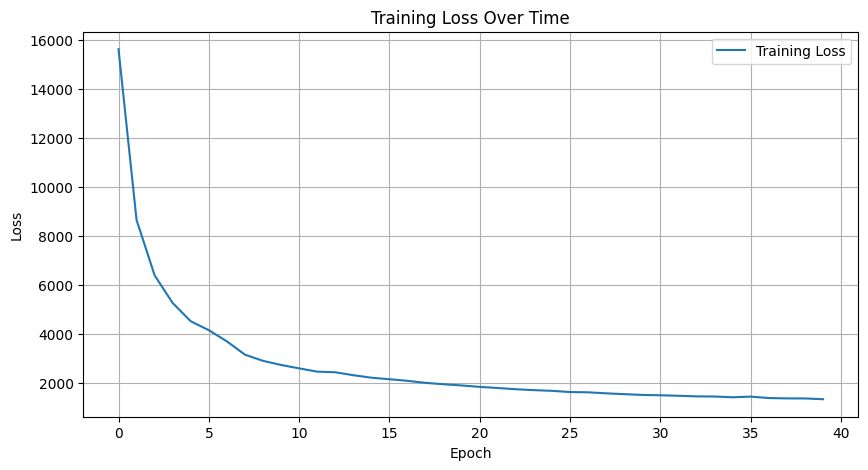

Checkpoint saved at C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver1_40_epochs_checkpoint.pth


In [ ]:
# Training

losses = []
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        
        # Forward pass
        reconstructed, latent = model(images)
        
        loss = ae_loss(reconstructed, images)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    epoch_loss = round(train_loss / len(dataloader.dataset), 4)
    clear_output(wait=True)  # Clear the previous plot
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
    losses.append(epoch_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    if (epoch+1) % 10 == 0:
        save_checkpoint(model, optimizer, epoch, f"C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver1_{epoch+1}_epochs_checkpoint.pth", losses)


In [13]:
checkpoint_path = "C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver1_100_epochs_checkpoint.pth"

# Load checkpoint if resuming
if os.path.exists(checkpoint_path):  # Ensure file exists
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # Start from next epoch
    losses = checkpoint.get('losses', [])  # Load previous losses if available
    print(f"Resuming training from epoch {start_epoch+1}")
else:
    start_epoch = 0
    losses = []


Loading checkpoint...
Resuming training from epoch 100


C:\Users\Gert\AppData\Local\Temp\ipykernel_7396\499506292.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Epoch [100/102], Loss: 876.3606


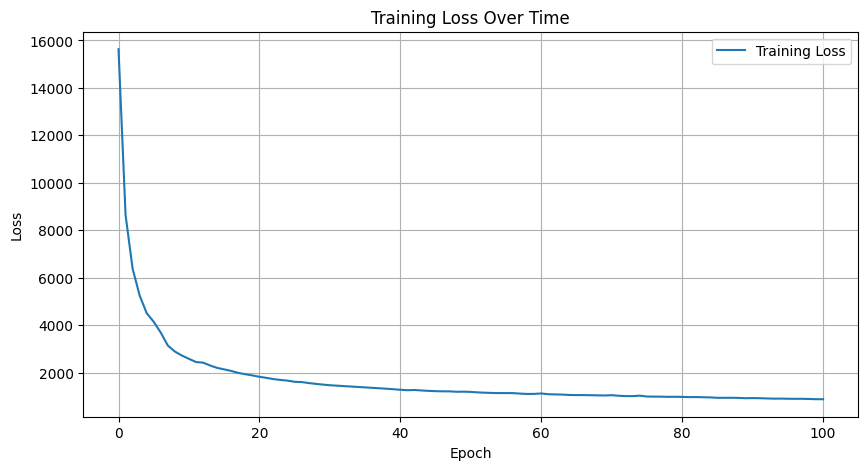

In [ ]:
# For continuing training
print(f"Continuing training from epoch {start_epoch+1}")
epochs = 102

for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        
        # Forward pass
        reconstructed, latent = model(images)
        
        loss = ae_loss(reconstructed, images)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    epoch_loss = round(train_loss / len(dataloader.dataset), 4)
    clear_output(wait=True)  # Clear the previous plot
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
    losses.append(epoch_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    if (epoch+1) % 10 == 0 and epoch != start_epoch:
        save_checkpoint(model, optimizer, epoch, f"C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver1_{epoch+1}_epochs_checkpoint.pth", losses)

In [13]:
model.eval()

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

C:\Users\Gert\AppData\Local\Temp\ipykernel_7396\1802307305.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(output[0].cpu()).shape)


(10, 3, 512, 512)


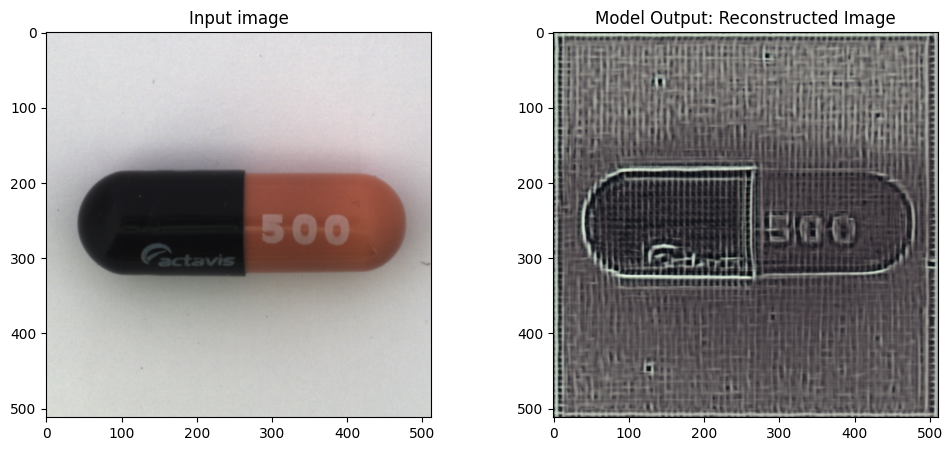

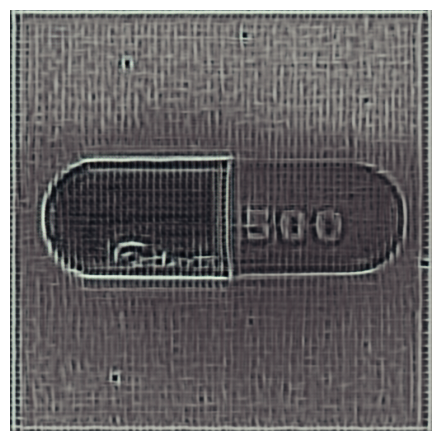

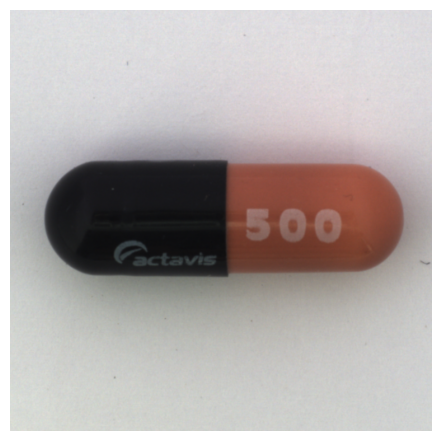

In [14]:
image = None
for i in dataloader:
    image = i
    break
# print(np.array(image[0][0]).shape)
image = image[0]
# print(image[0].reshape(512,512,-1).shape)
# plt.imshow(image[0].permute(1, 2, 0))
plt.show()
# image_normalized = (image - mean[None, :, None, None]) / std[None, :, None, None]  # Normalize along the channel dimension

# Send the normalized image to the same device as the model (e.g., GPU or CPU)
image = image.to(device)
model = model.to(device)

# Run the image through the model
with torch.no_grad():  # Disable gradient calculations for inference
    output = model(image)
print(np.array(output[0].cpu()).shape)
reconstructed_image = output[0][0]

reconstructed_image = reconstructed_image.permute(1, 2, 0).cpu()  # Convert (C, H, W) -> (H, W, C)

# Display the reconstructed image
# plt.imshow(reconstructed_image.cpu().numpy())
# plt.title("Model Output: Reconstructed Image")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(image[0].cpu().permute(1, 2, 0).numpy())
axes[0].set_title("Input image")
axes[1].imshow(reconstructed_image.cpu().numpy())
axes[1].set_title("Model Output: Reconstructed Image")
plt.show()

plt.imshow(reconstructed_image.cpu().numpy())
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

plt.imshow(image[0].cpu().permute(1, 2, 0).numpy())
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

C:\Users\Gert\AppData\Local\Temp\ipykernel_12172\905635763.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(image[0][0]).shape)


(3, 512, 512)


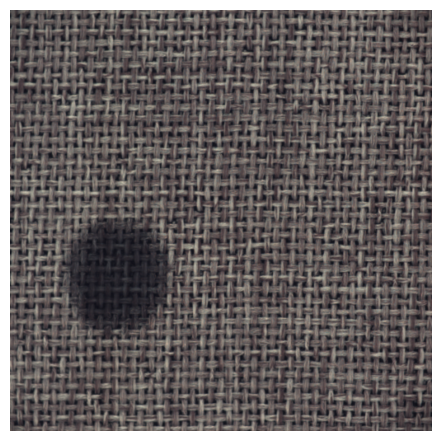

C:\Users\Gert\AppData\Local\Temp\ipykernel_12172\905635763.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(image).shape)


(10, 3, 512, 512)
(10, 3, 512, 512)


C:\Users\Gert\AppData\Local\Temp\ipykernel_12172\905635763.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(output[0].cpu()).shape)


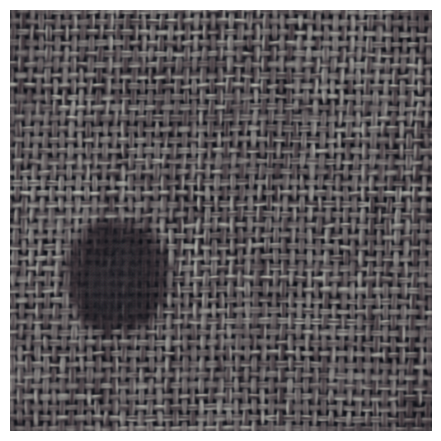

In [29]:
image = None
for i in test_dataloader:
    image = i
    break
print(np.array(image[0][0]).shape)
image = image[0]
plt.imshow(image[0].permute(1, 2, 0))
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()
# image_normalized = (image - mean[None, :, None, None]) / std[None, :, None, None]  # Normalize along the channel dimension

print(np.array(image).shape)
# Send the normalized image to the same device as the model (e.g., GPU or CPU)
image = image.to(device)
model = model.to(device)

# Run the image through the model
with torch.no_grad():  # Disable gradient calculations for inference
    output = model(image)
print(np.array(output[0].cpu()).shape)
reconstructed_image = output[0][0]

reconstructed_image = reconstructed_image.permute(1, 2, 0).cpu()  # Convert (C, H, W) -> (H, W, C)

# Display the reconstructed image
plt.imshow(reconstructed_image.cpu().numpy())
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()